In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

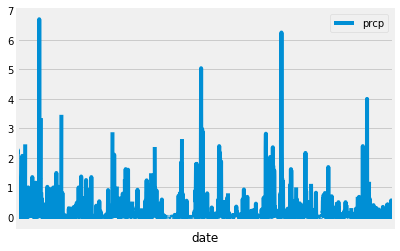

In [95]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).order_by(Measurement.date.desc()).all()
results
last_12_months= session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date > '2016-08-23')
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
x_ticks=[]
# Save the query results as a Pandas DataFrame and set the index to the date column
recent_df = pd.DataFrame(last_12_months)
total_measurement_df = pd.DataFrame(results)
# Sort the dataframe by date
recent_df.head()
recent_df=recent_df.sort_values('date')
dates=['06-23', '06-24', '06-25', '06-26', '06-27', '06-28', '06-29', '06-30']
# Use Pandas Plotting with Matplotlib to plot the data
recent_df.plot('date','prcp',xticks=x_ticks)


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
total_measurement_df['prcp'].describe()

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

In [13]:
# Design a query to show how many stations are available in this dataset?
unique_stations = session.query(Measurement).group_by(Measurement.station).count()
unique_stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
all_measures = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()
all_measures_df = pd.DataFrame(all_measures)
all_measures_df['station'].value_counts()


USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
filtered= all_measures_df.loc[all_measures_df['station']=='USC00519281',:]
lowest_temp = filtered['tobs'].min()
highest_temp= filtered['tobs'].max()
avg_temp=filtered['tobs'].mean()

print(lowest_temp)
print(highest_temp)
print(avg_temp)

54.0
85.0
71.66378066378067


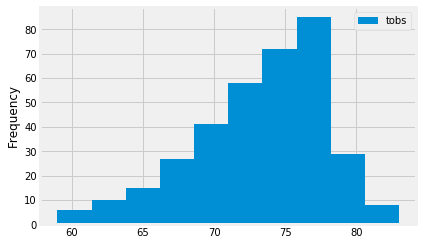

In [69]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
filtered_recent= filtered.loc[filtered['date'] > '2016-08-23']
filtered_recent.plot('date', 'tobs', kind='hist')

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_year_dates= calc_temps('2016-06-23', '2016-06-30')
last_year_dates

[(71.0, 76.76923076923077, 81.0)]

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
all_stations = session.query(Station.station, Station.name,Station.latitude, Station.longitude, Station.elevation).all()
all_stations= pd.DataFrame(all_stations)
merged = all_measures_df.merge(all_stations, how='inner', on='station')
merged_station_sum= merged.groupby('station').sum()
merged_station_sum=merged_station_sum.sort_values('prcp', ascending=False)
station_sum= merged_station_sum[['prcp','tobs']]
station_sum= station_sum.merge(all_stations, how='inner', on='station')
station_sum= station_sum[['station', 'name', 'prcp', 'latitude', 'longitude', 'elevation']]
station_sum

,station,name,prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1068.09,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",588.64,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",382.62,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",295.68,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",234.49,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",131.62,21.27160,-157.81680,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",92.68,21.31520,-157.99920,0.9
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",70.87,21.49920,-158.01110,306.6
8,USC00517948,"PEARL CITY, HI US",43.44,21.39340,-157.97510,11.9


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
first= daily_normals("06-23")
second= daily_normals("06-24")
third= daily_normals("06-25")
fourth= daily_normals("06-26")
fifth= daily_normals("06-27")
sixth= daily_normals("06-28")
seventh= daily_normals("06-29")
eighth= daily_normals("06-30")
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

TypeError: unsupported operand type(s) for -: 'str' and 'range'

In [28]:
print(first[0])
print(second[0])
print(third)
print(fourth)
print(fifth)
print(sixth)
print(seventh)
print(eighth)

(68.0, 74.54385964912281, 80.0)
(68.0, 74.96428571428571, 84.0)
[(68.0, 74.10344827586206, 80.0)]
[(67.0, 74.21428571428571, 82.0)]
[(66.0, 75.01785714285714, 81.0)]
[(69.0, 74.88679245283019, 80.0)]
[(67.0, 74.91525423728814, 80.0)]
[(67.0, 75.59615384615384, 81.0)]


In [43]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
zipped = zip(first[0],second[0], third[0], fourth[0], fifth[0], sixth[0], seventh[0], eighth[0])
trip_dates =pd.DataFrame(zipped, columns=['06-23', '06-24', '06-25', '06-26','06-27', '06-28', '06-29', '06-30'])
trip_dates= trip_dates.T
trip_dates

,0,1,2
06-23,68.0,74.543860,80.0
06-24,68.0,74.964286,84.0
06-25,68.0,74.103448,80.0
06-26,67.0,74.214286,82.0
06-27,66.0,75.017857,81.0
06-28,69.0,74.886792,80.0
06-29,67.0,74.915254,80.0
06-30,67.0,75.596154,81.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
